# An exploratory analysis on consumer complaints on financial products

This project is part of the "Write A Data Science Blog Post" of the Udacity Data Scientist nanodegress program. In this project, I will be exploring three things around consumer complaints:
1) The financial products consumers complaint about most frequently
2) The vocabulary of the complaint narrative and how they evolve over time
3) What particular types of narrative determine a timely response from the company

The data is downloaded from Consumer Financial Protection Bureau's Consumer Complaint Database, which, "is a collection of complaints about consumer financial products and services that we sent to companies for response". The data can be downloaded through API, but for convenience I downloaded the compressed csv file and read it in directly. Refer to "https://cfpb.github.io/api/ccdb/index.html" for more details about the data source.

## Load data and give a preliminary snapshot

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import missingno as msno

In [15]:
path = r"/Users/yanlinzhang/Desktop/Udacity/Data Scientist Certificate/Write a BlogPost"
df = pd.read_csv(os.path.join(path, "complaints.csv"))
df.head()

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_13013/1554581609.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, "complaints.csv"))


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-11-05,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",MO,63385,NaN,NaN,Web,2023-11-05,In progress,Yes,NaN,7803583
1,2023-11-05,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",VA,23325,NaN,NaN,Web,2023-11-05,In progress,Yes,NaN,7803584
2,2023-11-05,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",NC,27530,NaN,NaN,Web,2023-11-05,In progress,Yes,NaN,7803590
3,2023-11-05,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",NY,11967,NaN,NaN,Web,2023-11-05,In progress,Yes,NaN,7803591
4,2023-11-05,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",TX,76201,NaN,NaN,Web,2023-11-05,In progress,Yes,NaN,7803631


## 1. What types of product consumers complain about the most?

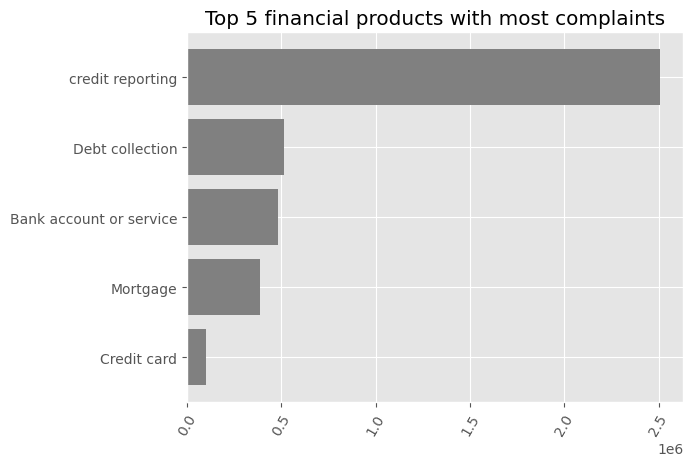

In [31]:
# Hnadle categorical variable: clean the raw strings and allocate them to proper categories for better visualization
df['Product'].replace({"Credit reporting, credit repair services, or other personal consumer reports": "credit reporting",
                       "Credit reporting or other personal consumer reports": "credit reporting",
                       "Checking or savings account": "Bank account or service",
                       "Credit card or prepaid card": "Bank account or service",
                       "Credit reporting": "credit reporting",
                       "Money transfer, virtual currency, or money service": "money service"},
                       inplace=True)


plt.style.use('ggplot')

product_dist = df['Product'].value_counts().sort_values(ascending=True)
plt.barh(list(product_dist.index)[-5:], list(product_dist.values)[-5:], color='grey')
plt.title("Top 5 financial products with most complaints")
plt.xticks(rotation='60')

plt.grid(True)

plt.savefig("top_products_complaints.png")

plt.show()

Using the product column info and undergoing some clean-up, the top five financial products with the highest number of complaints are: credit reporting, debt collection, bank account/service, mortgage, and credit card. Among the top categories, there are around 2.5 million complaints around credit reporting, significantly higher than any other top categories. It shows people are by far mostly dissatisfied with their credit reports, presumably being concerned with all sorts of errors or unexpected results. Other categories are also common topics people are likely to complain about. For example, there could be lots of different kinds of disputes around all sorts of debt, as well as the complexities around personal banking services and mortgages.

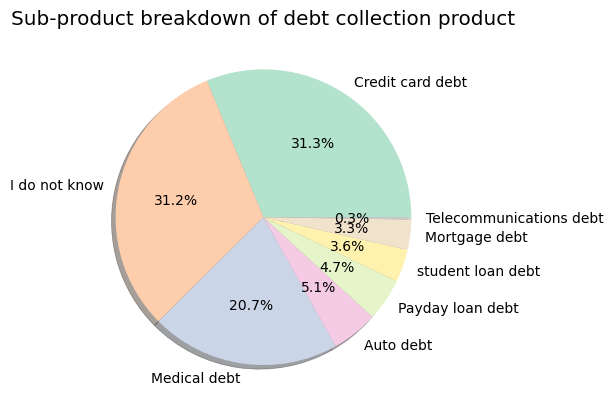

In [32]:
debt_sub_product = df[df['Product']=='Debt collection']['Sub-product']

# Same thing here, clean the entries of sub-product column to align the same types
debt_sub_product.replace({"Other (i.e. phone, health club, etc.)": "Other debt",
                          "Medical": "Medical debt",
                          "Credit card": "Credit card debt",
                          "Payday loan": "Payday loan debt",
                          "Mortgage": "Mortgage debt",
                          "Federal student loan debt": "student loan debt",
                          "Private student loan debt": "student loan debt",
                          "Auto": "Auto debt",
                          "Non-federal student loan": "student loan debt",
                          "Federal student loan": "student loan debt",
                          "Rental debt": "Mortgage debt"},
                          inplace=True)

# Exclude "other types" since it contains little information
debt_sub_product = debt_sub_product[~debt_sub_product.isin(['Other debt'])]

labels = debt_sub_product.value_counts().index
values = debt_sub_product.value_counts().values
explode = [0 for x in range(len(values))]

plt.style.use('ggplot')

plt.pie(values, labels=labels, shadow=True, autopct='%1.1f%%', colors=plt.cm.Pastel2.colors)
plt.title("Sub-product breakdown of debt collection product")

plt.savefig("top_subproducts_debt.png")


plt.show()

Though credit-reporting-related complaints are the most prominent product category, there are way too many sub-categories associated and it's hard to generalize them into larger groups. Therefore, I chose to breakdown the sub-products under debt collection complaints, the second highest product people complained about, roughly 500k+. Within debt collection, credit card debt makes up of the highest ratio, around 31% percent; medical debt comes next with an 20.7% percent; other frequent topics include auto debt, payday loan debt, student loan debt, mortgage debt, and telecommunications debt.

This exploratory result is in line with my expectation. Complaints around credit card debt should be the highest simply due to the prevalence of credit card usage around the nation; the same thing applies to medical debt. Other debt demands are a bit more case-dependent and not as ubiquitous.

## 2. How does the complaint narrative change over time?

This section dives into the actual narrative of tens of millions of complaints. This requires some basic text data cleaning, which includes lowercasing, stripping leading and trailing whitespaces, removing numbers, special characters, and stopwords, i.e., common English words like prepositions and articles that don't really provide much of information. Note that stemming and lemmatization are not done here just for the sake of saving computation effort and making things straightforward.

In [36]:
def clean_txt(txt_in):

    """
    This function provides a complete preliminary cleaning of the text columns by
    including removing special characters, converting to lower cases, stripping
    trailing and leading whitespaces, etc.
    """    


    import re
    if type(txt_in) == float:
        return ''
    tmp = txt_in.strip().lower()
    tmp = re.sub("'", ' ', tmp)
    tmp = re.sub('@[A-Za-z0-9_]+', ' ', tmp)
    tmp = re.sub('#[A-Za-z0-9_]+', ' ', tmp)
    tmp = re.sub(r'http\S+', ' ', tmp)
    tmp = re.sub(r'www.\S+', ' ', tmp)
    tmp = re.sub('[()!?]', ' ', tmp)
    tmp = re.sub('\[.*?\]',' ', tmp)
    tmp = re.sub('[^a-z0-9]',' ', tmp)
    tmp = re.sub('\d+', ' ', tmp)
    return tmp



def my_stop_words(var_in):

    """
    This function removes stopwords from the text columns using the very standard
    NLTK English stopwords library
    """

    from nltk.corpus import stopwords
    sw = stopwords.words('english')
    tmp = [word for word in var_in.split() if word not in sw]
    tmp = ' '.join(tmp)

    return tmp


def vader_senti(var):
    """
    This function uses the VADER sentiment dictionary to compute the average
    compound sentiment polarity score within each row of complaint narrative
    """


    from nltk.sentiment import SentimentIntensityAnalyzer
    senti_engine = SentimentIntensityAnalyzer()
    tmp = senti_engine.polarity_scores(var)["compound"]
    return tmp


def tb_senti(x):

    """
    Similar to the function above but this time uses the TextBlob sentiment
    polarity score instead of VADER compound score
    """

    from textblob import TextBlob
    return TextBlob(x).sentiment.polarity

My first approach is to explore the sentiment of the complaint narrative, i.e. is the overall tone neutral or negative? How negative? I utilized two frequently used libraries to compute the sentiment polary: TextBlob's sentiment polarity score and VADER's compound score (Valence Aware Dictionary and sEntiment Reasoner). Both score ranges from -1 to 1, with 1 being the most positive, -1 being the most negative, and 0 being completely neutral.

Again, due to the computation labor, I randomly sampled 10,000 documents (rows of complaint narrative) from the dataset, apply the cleaning and processing functions element-wise, and computed the mean sentiment polarity scores aggregated by years from 2015 to 2023. I also collected the number of documents over years to give a sense of evolving sample size.

In [37]:
df['date'] = pd.to_datetime(df['Date received'], errors='coerce')

# Randomly sample 10000 rows of complaints just to make data easy to work with
subset = df[['Consumer complaint narrative', 'date', 'Timely response?']].dropna()
subset = subset.sample(n=10000)

# Apply each of the text cleanning functions defined above
subset['narrative_cleaned'] = subset['Consumer complaint narrative'].apply(lambda x: clean_txt(x))
subset['narrative_cleaned_nosw'] = subset['narrative_cleaned'].apply(lambda x: my_stop_words(x))

# Compute sentiment polarity scores
subset['tb_senti'] = subset['narrative_cleaned_nosw'].apply(tb_senti)
subset['vader_senti'] = subset['narrative_cleaned_nosw'].apply(vader_senti)

In [38]:
# Aggregate the sentiment polarities scores and complaint counts by year to visualize the trend

subset['year'] = subset['date'].dt.year

trend = subset.groupby('year').agg(
    tb_mean = ('tb_senti', 'mean'),
    vader_mean = ('vader_senti', 'mean'),
    ct = ('narrative_cleaned_nosw', 'count')
    ).reset_index()

print(trend)

   year   tb_mean  vader_mean    ct
0  2015  0.011084    0.043972   351
1  2016  0.003215    0.060893   507
2  2017  0.000313    0.132387   765
3  2018  0.013173    0.094295   766
4  2019  0.009119    0.064948   800
5  2020  0.009885    0.102571  1117
6  2021  0.013733    0.070255  1313
7  2022  0.060370    0.073533  2193
8  2023  0.043461    0.080444  2188


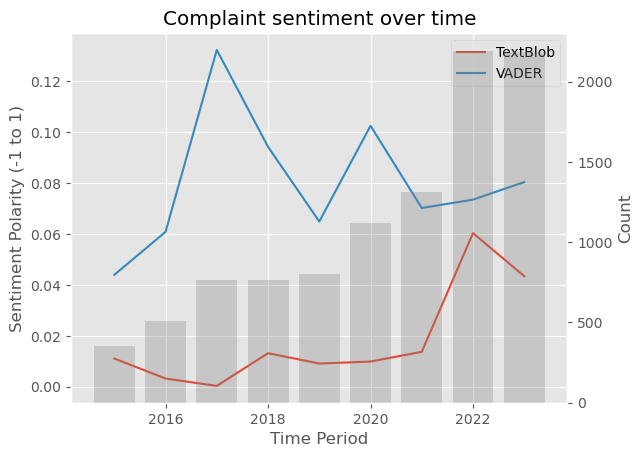

In [39]:
# Plot a time series graph to compare the trends of two types of sentiment polarity 

plt.style.use('ggplot')

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time Period')
ax1.set_ylabel('Sentiment Polarity (-1 to 1)')
ax1.plot(trend.year, trend.tb_mean, label='TextBlob')
ax1.plot(trend.year, trend.vader_mean, label='VADER')

ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Count') 
ax2.bar(trend.year, trend.ct, color='grey', alpha=0.3)


plt.title('Complaint sentiment over time')

plt.grid(False)

plt.savefig("complaint_sentiment_trend.png")

plt.show()



From this plot, we see that the overall sentiment across 10,000 complaint documents is quite consistent, oscillating within the range of 0 and 0.12, though the scale zooms in of this specific range so the sentiment looks more volatile than it actually was. In general, VADER's algorithm rates the complaints somewhat more positively, while it's hard to summarize an increasing or decreasing trend as the curve zig-zags. On the other hand, TextBlob, though displaying less positivity, still maintains a higher-than-zero score and rises more steadily overtime. This is a bit of a surprising result since complaints by themselves are expected to have negative polarity scores.

In [40]:
def remove_additional_sw(var_in):
    """
    Remove xxx tokens since they are censored consumer information that contains little info
    and contaminates the word cloud space
    """

    sw = ['x','xx','xxx','xxxx','xxxxx','xxxxxx','xxxxxxx','xxxxxxxx','xxxxxxxxx','xxxxxxxxxx']
    tmp = [word for word in var_in.split() if word not in sw]
    tmp = ' '.join(tmp)

    return tmp


subset['narrative_cleaned_nosw'] = subset['narrative_cleaned_nosw'].apply(remove_additional_sw)

# Split the texts by 2019 to see the vocab differences
before_19 = subset[subset['year']<2019]
after_19 = subset[subset['year']>=2019]

complaint_text_before = before_19['narrative_cleaned_nosw'].str.cat()
complaint_text_after = after_19['narrative_cleaned_nosw'].str.cat()

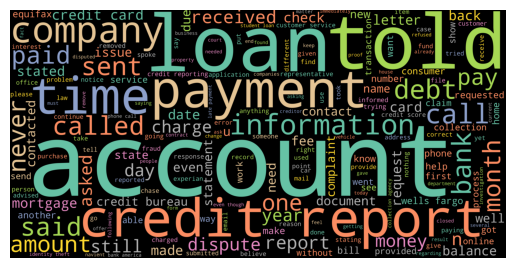

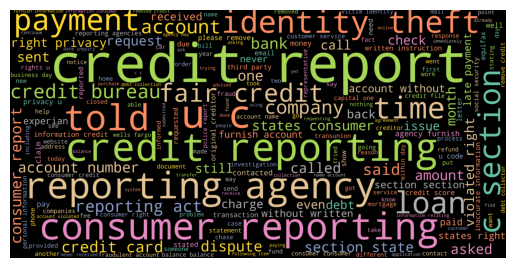

In [46]:
from wordcloud import WordCloud, STOPWORDS

# Use word cloud to illustrate the difference in vocabs before and after 2019

for text, i in zip([complaint_text_before, complaint_text_after], range(2)):

    wc = WordCloud(
        stopwords=STOPWORDS,
        background_color='black',
        colormap='Set2',
        random_state=42,
        height=3000,
        width=6000).generate(text)

    plt.imshow(wc)
    plt.axis('off')

    plt.savefig(f"wordcloud_{i}")

    plt.show()

Moreover, I additionally used 2019 as a turning point to split the documents in half and visualized each with the WordCloud, which is a cool method to display the words based on their frequency in the whole corpus. Before that, since there are lots of "xxx" in the corpurs, which are censored consumer information that doesn't really adds meaningful infrormation but appeared very often, I removed all of them to clean up the token space.

Based on the two images, despite the huge overlaps of narrative before and after 2019, earlier years place more focus on issues like account, payment, and loan, while the latter half's text space is dominated by credit reporting itself and agency or bureau that receives those kind of issues.

## 3. Can we predict if the complaint gets a timely response? 

Last but not least, I leveraged some popular text preprocessing and supervised learning techniques to play around the data and answer the following question: can we predict if the complaint gets a timely response? There are lots of ways to quantify text data and serves as feature inputs to supervised learning algorithms, bag-of-words, TF-IDF, wording embeddings like Word2Vec, gloVe, and so on. Right here I used TF-IDF (Term Frequency - Inverse Document Frequency) to vectorize the tokens and documents, which is more sophisticated than than BoW but remains interpretable unlike NN techniques. The target variable is binary, whether the company provides a timely response to the complaint, and the ML model is yet again a go-to choice known for its parsimony: logistic regression.

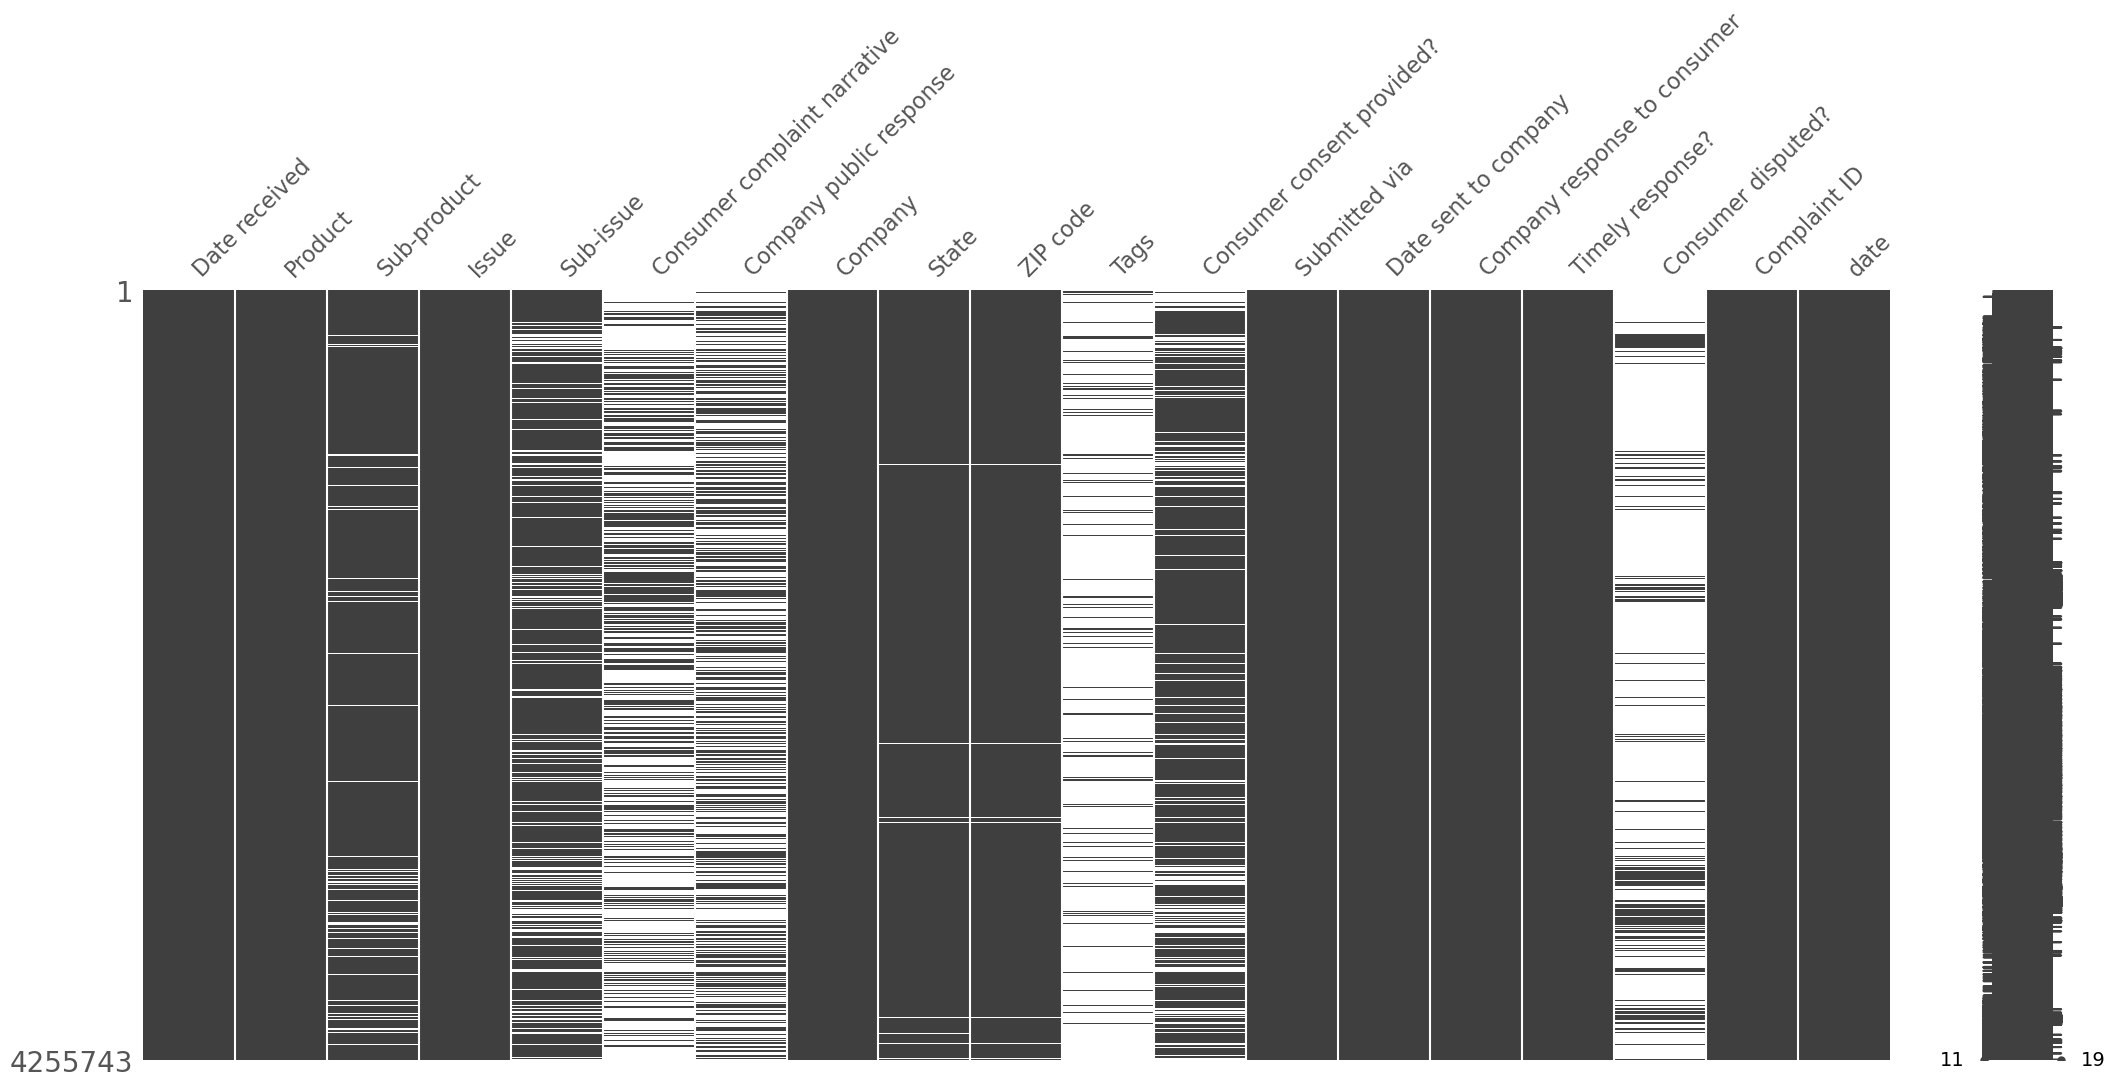

In [47]:
# Use the missingno library to plot the missing value distributions across all columns
msno.matrix(df)

plt.savefig("msno_plt.png")

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [26]:
# Use TF-IDF scheme to vectorize text data, sort of a go-to choice, better than bag of words

X = subset['narrative_cleaned_nosw']
y = subset['Timely response?'].replace({"Yes": 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

tfidf = TfidfVectorizer(ngram_range=(1, 2)).fit(X_train)

tfidf_train = tfidf.transform(X_train)
tfidf_test = tfidf.transform(X_test)


In [27]:
# Fit logistic regression to our data and evaluate

tfidf_feature_names = tfidf.get_feature_names()
print(f"Number of features: {len(tfidf_feature_names)}")

logit_tfidf=LogisticRegression().fit(tfidf_train, y_train)
print(f"Training set score: {logit_tfidf.score(tfidf_train,y_train):.5f}")
print(f"Test set score: {logit_tfidf.score(tfidf_test,y_test):.5f}")

Number of features: 273480
Training set score: 0.98493
Test set score: 0.98480


I fitted a simple logistic regression to the training data and tested it on the out-of-sample set, and the accuracy scores are 0.98493 and 0.98480 respectively. This is an extremely high score, and there is almost no difference between training and test scores which indicates little overfitting. However, accuracy as a metric can be sometimes very misleading especially when the binary classes are imbalanced. Therefore, I computed the AUROC (area under ROC curve) and plotted the ROC (Receiver Operating Characteristic) Curve to evaluate the prediction. In this case, a 0.72 AUC is not outstanding anymore, since 0.5 means completely useless classification, and the false positive rate is much higher than expected along the way.

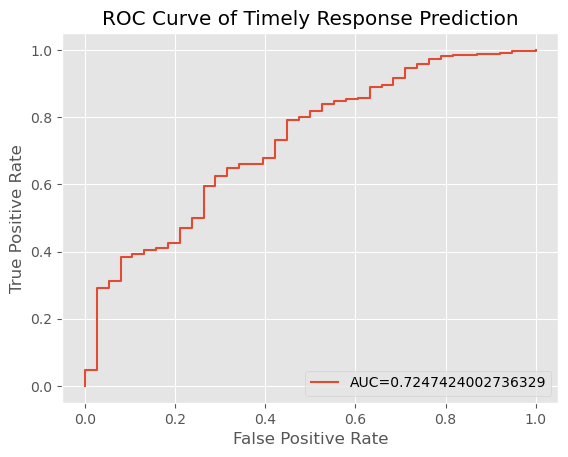

In [48]:
# Evaluate the binary classification model a bit further by employment classic AUROC metric

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = logit_tfidf.predict_proba(tfidf_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))

plt.title("ROC Curve of Timely Response Prediction")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc=4)

plt.savefig("auroc.png")

plt.show()

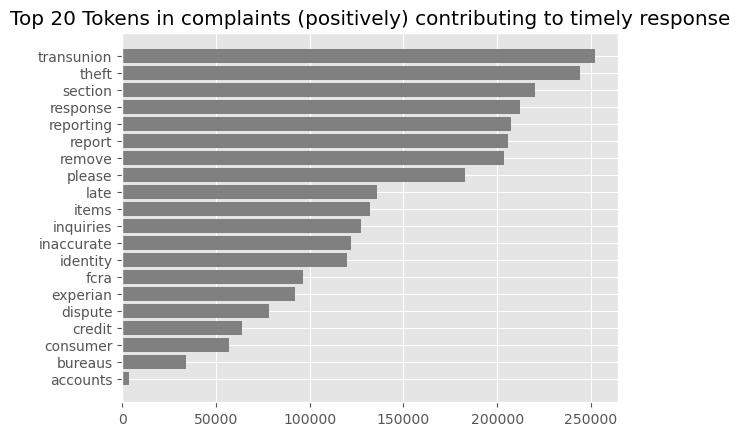

In [49]:
# Pick the top 20 coefs and associated tokens

tfidf_coefs = logit_tfidf.coef_
tfidf_feature_names = tfidf.get_feature_names()

coefs = tfidf_coefs.squeeze().ravel()
positive_coefficients = sorted(np.argsort(coefs)[-20:])

feature_names = np.array(tfidf_feature_names)[positive_coefficients]

# Plot horizontally to make it look more clear
plt.barh(feature_names, positive_coefficients, color='grey')
plt.title("Top 20 Tokens in complaints (positively) contributing to timely response")

plt.grid(True)

plt.savefig("logit_coef.png")

plt.show()

Last but not least, a good thing with logistic regression is its coefficients. Based on the magnitude and sign, we are able to know the direction and significance of certain token's effect on timely response. The bar plot above visualizes the top 20 tokens that positively contributes to timely response, including transunion, theft, section, reporting, please, late, inaccurate, identity, etc. Some of them are serious words that the companies would more likely to look into the issue in time, and polite words are shown to make things work as well.